In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from datetime import datetime 
from sklearn.metrics import roc_auc_score as auc 

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [8]:
df = pd.read_csv('creditcard.csv')

## Split data by 50-50

In [10]:
TEST_RATIO = 0.5
df.sort_values('Time', inplace = True)
TRA_INDEX = int((1-TEST_RATIO) * df.shape[0])
train_x = df.iloc[:TRA_INDEX, 1:-2].values
train_y = df.iloc[:TRA_INDEX, -1].values

test_x = df.iloc[TRA_INDEX:, 1:-2].values
test_y = df.iloc[TRA_INDEX:, -1].values

## Pre-processing - z scores

In [11]:
cols_mean = []
cols_std = []
for c in range(train_x.shape[1]):
    cols_mean.append(train_x[:,c].mean())
    cols_std.append(train_x[:,c].std())
    train_x[:, c] = (train_x[:, c] - cols_mean[-1]) / cols_std[-1]
    test_x[:, c] =  (test_x[:, c] - cols_mean[-1]) / cols_std[-1]

## import RBM

In [21]:
from rbm import RBM

## Initialize model object with momentum

In [42]:
model = RBM(train_x.shape[1], 10, visible_unit_type='gauss', main_dir='/home/weimin/rbm/model', model_name='rbm_model.ckpt',
                 gibbs_sampling_steps=4, learning_rate=0.001, momentum = 0.95, batch_size=512, num_epochs=10, verbose=1)


## Train it and plot training reconstruction loss v.s. iteractions

Validation cost at step 0: 1.09903
Validation cost at step 1: 1.06755
Validation cost at step 2: 1.01456
Validation cost at step 3: 0.991753
Validation cost at step 4: 1.00508
Validation cost at step 5: 0.98341
Validation cost at step 6: 0.988588
Validation cost at step 7: 0.994976
Validation cost at step 8: 0.996031
Validation cost at step 9: 0.994955


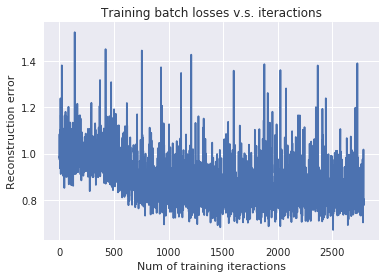

In [43]:
model.fit(train_x, validation_set=test_x)


## Make predictions on val - Free Energy

In [54]:
test_cost = model.getFreeEnergy(test_x).reshape(-1)


INFO:tensorflow:Restoring parameters from /home/weimin/rbm/model/rbm_model.ckpt


## AUC-ROC curve on val

In [55]:
auc(test_y, test_cost)

0.9637181344325112

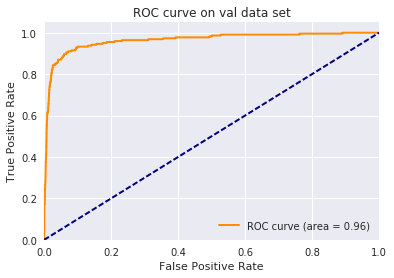

In [83]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(test_y, test_cost)

fpr_micro, tpr_micro, _ = roc_curve(test_y, test_cost)
roc_auc = auc(fpr_micro, tpr_micro)

plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on val data set')
plt.legend(loc="lower right")
plt.show()

## Distribution for FE on val set - fraud and non-fraud

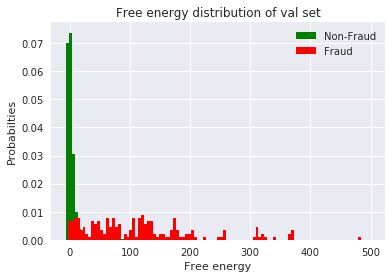

In [61]:
#plt.hist(test_cost[np.where(test_y == 1)], bins = 100)
plt.title('Free energy distribution of val set')
plt.xlabel('Free energy')
plt.ylabel('Probabilties')
plt.hist(test_cost[(test_y == 0) & (test_cost < 500)], bins = 100, color='green', normed=1.0, label='Non-Fraud')
plt.hist(test_cost[(test_y == 1) & (test_cost < 500)], bins = 100, color='red', normed=1.0, label = 'Fraud')

plt.legend(loc="upper right")
plt.show()

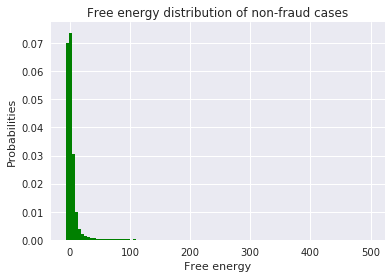

In [62]:
#plt.hist(test_cost[np.where(test_y == 1)], bins = 100)
plt.hist(test_cost[(test_y == 0) & (test_cost < 500)], bins = 100, color='green', normed=1)
plt.title('Free energy distribution of non-fraud cases')
plt.xlabel('Free energy')
plt.ylabel('Probabilities')
plt.show()

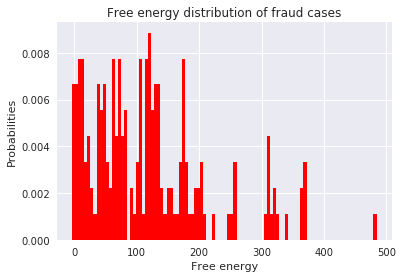

In [63]:
#plt.hist(test_cost[np.where(test_y == 1)], bins = 100)
plt.hist(test_cost[(test_y == 1) & (test_cost < 500)], bins = 100, color='red', normed=1)
plt.title('Free energy distribution of fraud cases')
plt.xlabel('Free energy')
plt.ylabel('Probabilities')
plt.show()

## Finding a threshold for real time fraud detector

### Precision Recall Curve in general

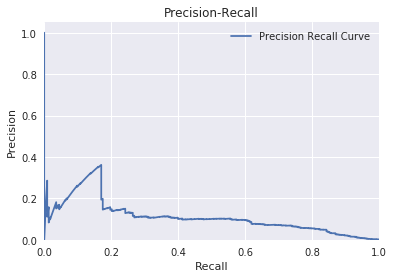

In [86]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall(lines):
    

    for precision, recall, label in lines:
        plt.plot(recall, precision, label=label)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall')
    plt.legend(loc="upper right")
    plt.show()
    
lines = []
precision, recall, threshold = precision_recall_curve(test_y, test_cost)

lines.append( (precision, recall, 'Precision Recall Curve') )
plot_precision_recall(lines)

### Finding a threshold of Free Energy on range(0, 200) that best balances Precision and Recall

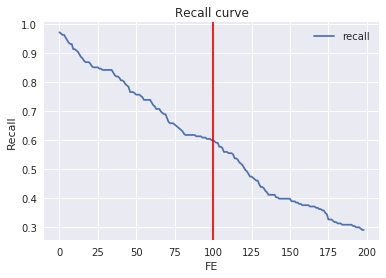

In [81]:
precisions = []
recalls = []
all_pos = sum(test_y)
for threshold in range(1, 200):
    all_predicted = sum(test_cost > threshold)
    TP = sum((test_cost > threshold) & (test_y == 1))
    
    precisions.append(TP  / all_predicted)
    recalls.append(TP / all_pos)

plt.plot( recalls, label = 'recall')
plt.axvline(100, color = 'red')

plt.title("Recall curve")
plt.xlabel("FE")
plt.ylabel("Recall")
plt.legend()
plt.show()

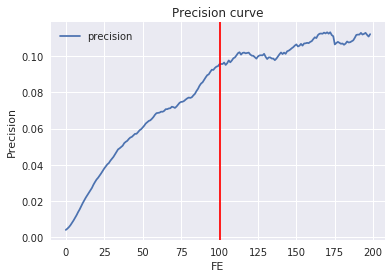

In [82]:
plt.plot( precisions, label = 'precision')
plt.axvline(100, color = 'red')

plt.title("Precision curve")
plt.xlabel("FE")
plt.ylabel("Precision")
plt.legend()
plt.show()

## Take a look at the top 500 transactions for example ....

In [122]:
value_500 = sorted(test_cost)[-500]
population_mean = np.mean(test_y)
model_mean_500 = np.mean(test_y[test_cost > value_500])
print("Perc of fraud in val data is: %0.2f%%; perc of fraud in top 500 by model is: %0.2f%%" % (population_mean*100, model_mean_500*100))

Perc of fraud in val data is: 0.16%; perc of fraud in top 500 by model is: 11.82%
